In [30]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.folder_handler import *
from src.cort_processor import *
from src.cca_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
import pickle
import scipy as spicy
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
path = '/home/diya/Documents/rat-fes/data/filipe_data/N5'
filenames = os.listdir(path)

temp_datasets = []
temp_var_names = []

for file in filenames:
    temp_datasets.append(path+'/'+file)
    temp_var_names.append(file.split('_')[0]+file.split('_')[1])

datasets = sorted(temp_datasets)
var_names = sorted(temp_var_names)

print(filenames)

['N5_171130_No Obstacles_s.mat', 'N5_171016_No Obstacles_s.mat', 'N5_171001_No Obstacles_s.mat', 'N5_170929_No Obstacles_s.mat']


In [5]:
cort_dict = {}
for i in range(len(datasets)):
    cort_dict[var_names[i]] = CortProcessor(datasets[i])
    
cca_dict = {}
for i in range(1, len(var_names)):
    print(var_names[0], var_names[i])
    cca_dict[var_names[i]] = CCAProcessor(cort_dict[var_names[0]], cort_dict[var_names[i]])


this is filipe data i belive
this is filipe data i belive
this is filipe data i belive
this is filipe data i belive
N5170929 N5171001
should be good to align
(9594, 11)
(9594, 5)
(9594, 23)
(9594, 5)
N5170929 N5171016
should be good to align
(9594, 11)
(9594, 5)
(9594, 22)
(9594, 5)
N5170929 N5171130
should be good to align
(9594, 11)
(9594, 5)
(9594, 23)
(9594, 5)


In [17]:
proc_vaf_scores = []
proc_y_list = []

temp = np.average(cca_dict[var_names[1]].data['cp1']['proc_vaf'], 1)
proc_vaf_scores.append(temp)

temp = cca_dict[var_names[1]].data['cp1']['proc_y']
proc_y_list.append(temp)

for i in range(1, len(var_names)):
    temp = np.average(cca_dict[var_names[i]].data['cp2']['proc_vaf'],1)
    proc_vaf_scores.append(temp)
    
    temp = cca_dict[var_names[i]].data['cp2']['proc_y']
    proc_y_list.append(temp)
        
    temp = cca_dict[var_names[1]].data['cp1']['proc_y'].shape[0]
    if proc_y_list[0].shape[0] > temp:
        proc_y_list[0] = temp
#proc_vaf_scores.append(cca_dict[var_names[0]].cp1.vaf

In [18]:
lowest_num_dimensions = 33


for i in range(1, len(var_names)):
    temp, nada, nada = cca_dict[var_names[i]].PCA_to_same_dimensions()
    lowest_num_dimensions = min(lowest_num_dimensions, temp)
    if temp==lowest_num_dimensions:
        low_dim = var_names[i]
    
print(str(low_dim) + ': ' + str(lowest_num_dimensions))

N5171130: 6


In [19]:
pca_x_list = []

for i in range(1, len(var_names)):
    nada, nada, temp_x = cca_dict[var_names[i]].PCA_to_same_dimensions(preset_num_components = lowest_num_dimensions)
    pca_x_list.append(temp_x)
    
nada, temp_x, nada = cca_dict[var_names[1]].PCA_to_same_dimensions(preset_num_components = lowest_num_dimensions)
pca_x_list.insert(0, temp_x)

In [20]:
pca_h_matrices = []
pca_vaf_list = []
proc_y_list_format = []
pca_x_list_format = []
for i in range(len(pca_x_list)):
    print(pca_x_list[i].shape, proc_y_list[i].shape)
    temp_x, temp_y = format_data(pca_x_list[i], proc_y_list[i])
    pca_x_list_format.append(temp_x)
    proc_y_list_format.append(temp_y)
    
    temp_h, temp_vaf, nada, nada = decode_kfolds(temp_x, temp_y)
    pca_h_matrices.append(temp_h)
    pca_vaf_list.append(np.round((np.average(temp_vaf,1)), 2))
    
    

(9594, 6) (9594, 5)
(9594, 6) (9594, 5)
(9594, 6) (9594, 5)
(9594, 6) (9594, 5)


In [86]:
x = pca_x_list_format[3]
y = proc_y_list_format[3]
b0= pca_h_matrices[0]

In [87]:
predic = test_wiener_filter(x, b0)

In [88]:
y_star = y - predic
x_plus_bias = np.c_[np.ones((np.size(x, 0), 1)), x]

In [89]:
clf = Ridge(alpha=5.0)
clf.fit(x_plus_bias, y_star)

Ridge(alpha=5.0)

In [90]:
Wpost = clf.coef_.T
print(Wpost.shape)

(61, 5)


In [91]:
b = Wpost - b0

In [92]:
test = test_wiener_filter(x, b)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
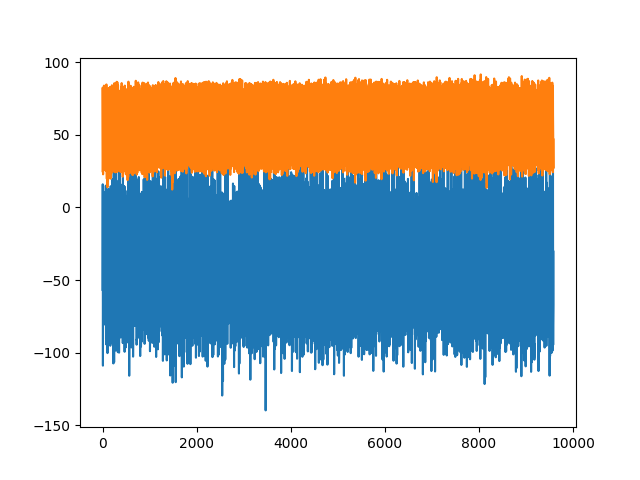

In [93]:
fig, ax = plt.subplots()
ax.plot(test[:,1])
ax.plot(y[:,1])